Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Алина Ломоносова"
COLLABORATORS = ""

---

In [2]:
import numpy as np
from scipy.linalg import block_diag

Рассмотрим систему линейных уравнений, матрица правой части которой является "ленточной" и имеет следующую структуру: ненулевые элементы расположены на трех центральных диагонялях и на двух "крыльях". Матрицы такой структуры возникают, например, при решении задачи на нахождение электростатического потенциала $\phi(x, y)$, cоздаваемого двумерным распределением заряда $\rho(x, y)$ при дискретизации на сетке уравнения Пуассона

$$
\Delta \phi = -4\pi \rho\;.
$$

(детали см. напр. А.А. Самарский, А.В. Гулин, Численные методы, ч. 3 гл. 1, параграф 1).

Размер матрицы растет с уменьшением шага сетки $h$ как $O(1/h^2)$. Таким образом, приходится иметь дело с разреженными матрицами огромного размера.

Матрицу `m` создадим следующим образом:

In [3]:
def lhs_matrix(n):
    # Диагональный блок
    a = np.zeros((n-1, n-1))

    idx = np.arange(n-1)

    a[idx, idx] = -4
    a[idx[:-1], idx[:-1]+1] = 1
    a[idx[1:], idx[1:]-1] = 1

    # собираем блочно-диагональную матрицу `m`
    m = block_diag(*(a,)*n)

    # заполняем "крылья"
    idx = np.arange(m.shape[0])

    m[idx[:-n+1], idx[:-n+1] + n-1] = 1
    m[idx[n-1:], idx[n-1:] - n+1] = 1
    return m

In [4]:
m = lhs_matrix(5)

with np.printoptions(linewidth=99):
    print(m)

[[-4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0

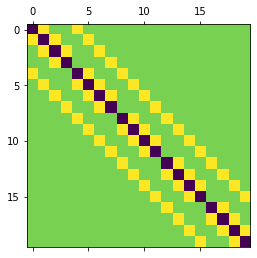

In [5]:
import matplotlib.pyplot as plt
plt.matshow(m)

Зададим вектор правой части системы $b$, символизирующий точечный заряд в центре:

In [6]:
b = np.zeros(m.shape[0])
b[m.shape[0]//2] = -1

Составьте функцию, вычисляющую решение системы уравнений $m x = b$ **методом Зейделя** с заданной точностью $\epsilon$.

Не пользуйтесь функциями `np.linalg.solve`, `np.linalg.inv` и т.п. Обратите внимание на функции `np.triu` и `scipy.linalg.solve_triangular`.

In [7]:
from scipy.linalg import solve_triangular

def seidel_solve(m, b, x0, eps=1e-5, maxiter=500):
    """ Solve `m @ x = b` with Seidel iteration.
    
    Parameters
    ----------
    m : ndarray, shape (n, n)
       Input matrix
    b : ndarray, shape (n,)
       Right-hand side
    x0 : ndarray, shape (n, )
       Initial point for the iteration
    eps : float, optional
       Target accuracy.
       Stop iterations when the 2-norm of 
       `|x_k - x_{k-1}| < eps`
    maxiter : int
       Maximum allowed number of iterations.
       
    Returns
    -------
    x : ndarray, shape (n,)
       The approximation to the solution of `m @ x = b`
    nit : the number of iterations performed.
    """
    L = np.tril(m)
    U = np.triu(m, 1)

    for i in range(maxiter):
        new_x = solve_triangular( L, b - U @ x0, lower = True)
        
        if np.linalg.norm(new_x - x0) < eps:
            break
        x0 = new_x

    return new_x, i    


In [8]:
m = lhs_matrix(n=6)
b = np.zeros(m.shape[0])
b[b.size//2] = 1

x0 = np.ones(m.shape[0])
x, nit = seidel_solve(m, b, x0)

from numpy.testing import assert_allclose
assert_allclose(x,
                np.linalg.solve(m, b), atol=2e-5)

### BEGIN HIDDEN TESTS
m = lhs_matrix(n=15)
b = np.zeros(m.shape[0])
b[b.size//2] = 1

ground_truth = np.linalg.solve(m, b)


# try stubbing out solve/inv
try:
    np.linalg.solve = None
    np.linalg.inv = None
except:
    pass

x0 = np.ones(m.shape[0])
x, nit = seidel_solve(m, b, x0, eps=1e-6, maxiter=1000)

assert_allclose(x, ground_truth, atol=5e-6)
### END HIDDEN TESTS

Прокомментируйте зависимость числа итераций, требуемых для достижения заданной точности, от $\epsilon$. (без оценки)

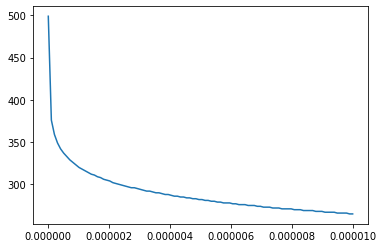

In [9]:
accuraces = np.linspace(1e-10, 1e-5, 100)
errors = [seidel_solve(m, b, x0, eps)[1] for eps in accuraces]

plt.plot(accuraces, errors)

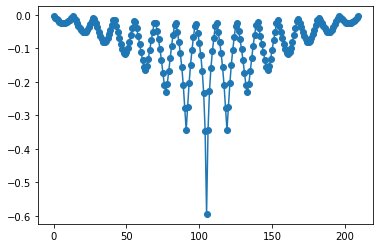

In [10]:
# Постройте график решения как функцию индекса компоненты вектора. 
# Прокомментируйте характер зависимости (без оценки).
plt.plot(x, 'o-')